In [36]:
!pip install torchvision
!pip install torch scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [37]:
import zipfile
import os
from PIL import Image
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [38]:
import os

image_folder = '/user/HS400/sv00653/Desktop/kaggle/Dataset_train'
image_files = os.listdir(image_folder)
print(f'Found {len(image_files)} files in the folder.')


Found 6122 files in the folder.


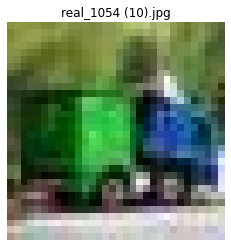

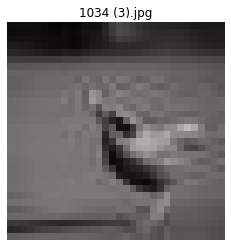

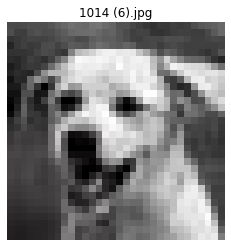

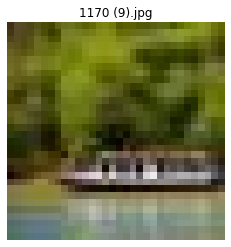

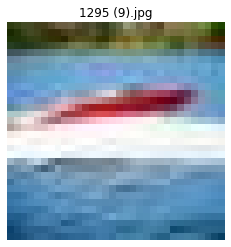

In [39]:
for idx, image_file in enumerate(image_files):
    if idx >= 5:
        break
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

In [40]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image

In [41]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [42]:
dataset = CustomImageDataset(img_dir=image_folder, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [43]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [44]:
class ResNet18Encoder(nn.Module):
    def __init__(self):
        super(ResNet18Encoder, self).__init__()
        self.layer1 = self._make_layer(3, 64, 2)  
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

In [45]:
class ResNet18Decoder(nn.Module):
    def __init__(self):
        super(ResNet18Decoder, self).__init__()
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # Upsample to 16x16
        self.layer1 = self._make_layer(256, 256, 2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Upsample to 32x32
        self.layer2 = self._make_layer(128, 128, 2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample to 64x64
        self.layer3 = self._make_layer(64, 64, 2)
        self.upconv4 = nn.ConvTranspose2d(64, 3, kernel_size=1, stride=1, padding=0)  # Upsample to 128x128

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.upconv1(x)
        x = self.layer1(x)
        x = self.upconv2(x)
        x = self.layer2(x)
        x = self.upconv3(x)
        x = self.layer3(x)
        x = self.upconv4(x)
        return x

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = ResNet18Encoder().to(device)
decoder = ResNet18Decoder().to(device)
model = nn.Sequential(encoder, decoder).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 25
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Found 2040 files in the folder.


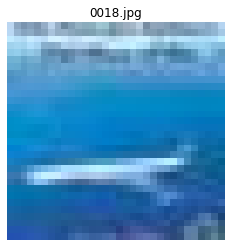

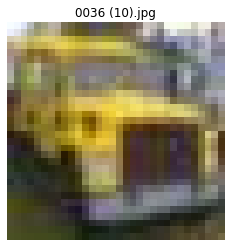

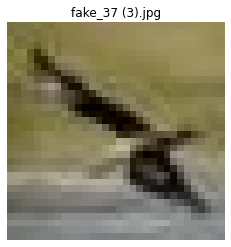

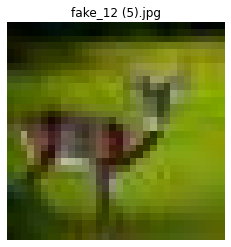

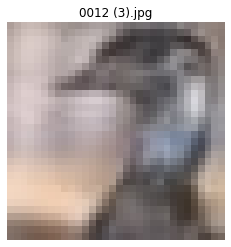

In [49]:

testimage_folder = '/user/HS400/sv00653/Desktop/kaggle/Dataset_test'
testimage_files = os.listdir(testimage_folder)
print(f'Found {len(testimage_files)} files in the folder.')
for idx, testimage_file in enumerate(testimage_files):
    if idx >= 5:
        break
    testimage_path = os.path.join(testimage_folder, testimage_file)
    testimage = Image.open(testimage_path)
    plt.imshow(testimage)
    plt.title(testimage_file)
    plt.axis('off')
    plt.show()

In [50]:
testdataset = CustomImageDataset(img_dir=testimage_folder, transform=transform)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=True)

Shape of images for visualization: torch.Size([32, 3, 128, 128])
Shape of outputs for visualization: torch.Size([32, 3, 128, 128])


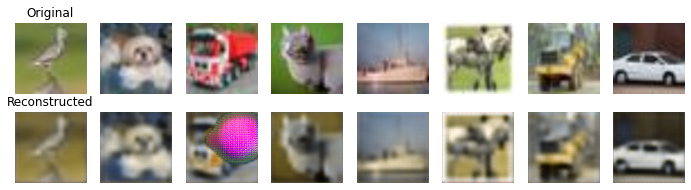

In [51]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        images = images.cpu()
        outputs = outputs.cpu()
        break

print(f'Shape of images for visualization: {images.shape}')
print(f'Shape of outputs for visualization: {outputs.shape}')


fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(12, 3))
for i in range(8):
    original_image = np.clip(np.transpose(images[i].detach().numpy(), (1, 2, 0)), 0, 1)
    reconstructed_image = np.clip(np.transpose(outputs[i].detach().numpy(), (1, 2, 0)), 0, 1)
    axes[0, i].imshow(original_image)
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_image)
    axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed')
plt.show()


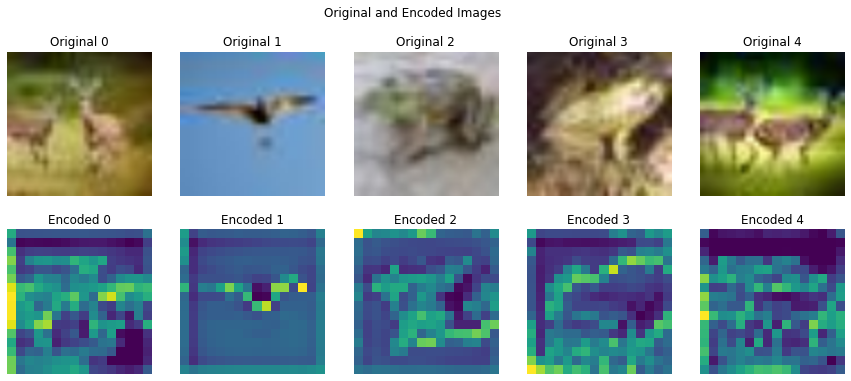

In [52]:
encoder.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        latent_vectors = encoder(images)
        break

latent_vectors = latent_vectors.cpu().numpy()
images = images.cpu().numpy()


fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(np.moveaxis(images[i], 0, -1))  
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i}')

    # Encoded images (latent space representation)
    im = axes[1, i].imshow(latent_vectors[i, 0], cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Encoded {i}')
    

plt.suptitle('Original and Encoded Images')
plt.show()


In [53]:
from sklearn.mixture import GaussianMixture 
from torch.distributions.kl import kl_divergence
from torch.distributions import Normal, MultivariateNormal
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

In [54]:

fake_image_dataset = CustomImageDataset(img_dir='/user/HS400/sv00653/Desktop/kaggle/fake', transform=transform)

fake_image_loader = DataLoader(fake_image_dataset, batch_size=32, shuffle=False)
real_image_dataset = CustomImageDataset(img_dir='/user/HS400/sv00653/Desktop/kaggle/real', transform=transform)


real_image_loader = DataLoader(real_image_dataset, batch_size=32, shuffle=False)

In [55]:
encoder = nn.Sequential(*list(model.children())[:4])  

real_encoded_outputs = []
simulated_encoded_outputs = []

encoder.eval()  
with torch.no_grad():
    for real_images, _ in real_image_loader:
        real_images = real_images.to(device)
        real_encoded = encoder(real_images)  
        real_encoded = real_encoded.view(real_encoded.size(0), -1) 
        real_encoded_outputs.append(real_encoded.cpu().numpy())

    for simulated_images, _ in fake_image_loader:
        simulated_images = simulated_images.to(device)
        simulated_encoded = encoder(simulated_images)  
        simulated_encoded = simulated_encoded.view(simulated_encoded.size(0), -1)  
        simulated_encoded_outputs.append(simulated_encoded.cpu().numpy())

real_encoded_outputs = np.concatenate(real_encoded_outputs, axis=0)
simulated_encoded_outputs = np.concatenate(simulated_encoded_outputs, axis=0)

print(f"Real encoded outputs shape: {real_encoded_outputs.shape}")
print(f"Simulated encoded outputs shape: {simulated_encoded_outputs.shape}")


Real encoded outputs shape: (683, 49152)
Simulated encoded outputs shape: (683, 49152)


In [56]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42) 
real_encoded_reduced = tsne.fit_transform(real_encoded_outputs)
simulated_encoded_reduced = tsne.fit_transform(simulated_encoded_outputs)

print(f"Reduced real encoded outputs shape: {real_encoded_reduced.shape}")
print(f"Reduced simulated encoded outputs shape: {simulated_encoded_reduced.shape}")

gmm_real = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm_real.fit(real_encoded_reduced)

gmm_simulated = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm_simulated.fit(simulated_encoded_reduced)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Reduced real encoded outputs shape: (683, 2)
Reduced simulated encoded outputs shape: (683, 2)


GaussianMixture(n_components=10, random_state=42)

In [57]:
real_sampled, _ = gmm_real.sample(500000)  
log_prob_real = gmm_real.score_samples(real_sampled)
log_prob_simulated = gmm_simulated.score_samples(real_sampled)

kl_divergence = np.mean(log_prob_real - log_prob_simulated)
print(f"Approximate KL Divergence: {kl_divergence:.4f}")

Approximate KL Divergence: 0.8977


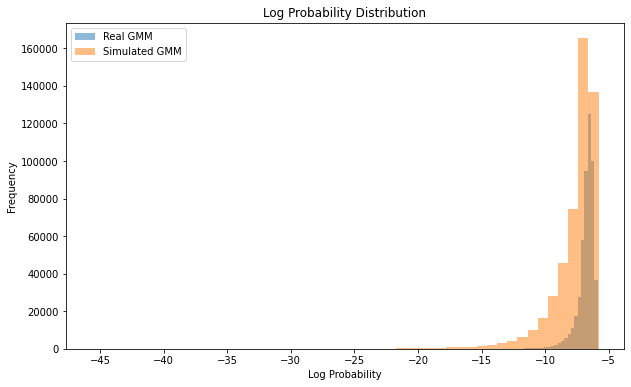

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(log_prob_real, bins=50, alpha=0.5, label='Real GMM')
plt.hist(log_prob_simulated, bins=50, alpha=0.5, label='Simulated GMM')
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.title('Log Probability Distribution')
plt.legend()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(kl_per_sample, bins=50, alpha=0.7, color='lightblue')
plt.xlabel('KL Divergence per Sample')
plt.ylabel('Frequency')
plt.title('KL Divergence Distribution between Real and Simulated Images')
plt.show()


In [60]:
labels_real = gmm_real.predict(real_encoded_reduced)
labels_simulated = gmm_simulated.predict(simulated_encoded_reduced)

print(f"Cluster assignments for Real Data: {np.bincount(labels_real)}")
print(f"Cluster assignments for Simulated Data: {np.bincount(labels_simulated)}")


Cluster assignments for Real Data: [126  79  88  92  50  52  35  57  56  48]
Cluster assignments for Simulated Data: [ 66  35  82 109  71 111  60  22  76  51]


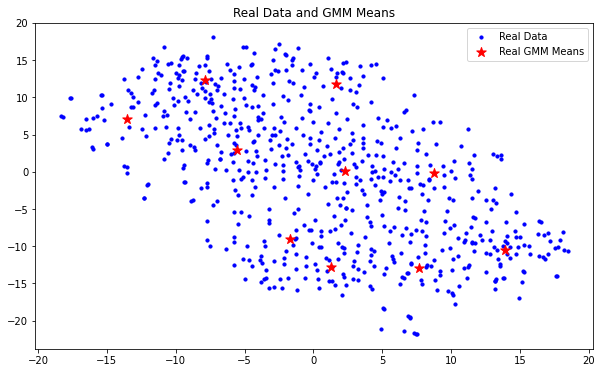

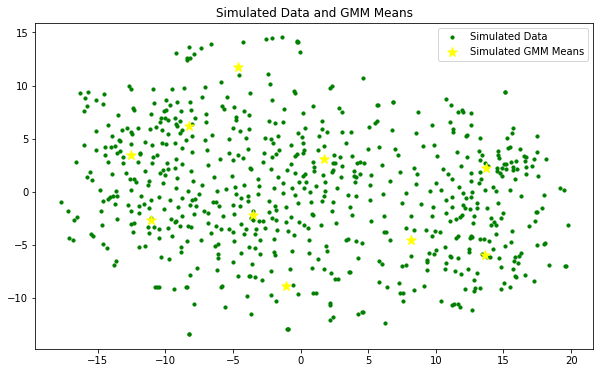

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(real_encoded_reduced[:, 0], real_encoded_reduced[:, 1], s=10, label='Real Data', color='blue')
plt.scatter(gmm_real.means_[:, 0], gmm_real.means_[:, 1], s=100, c='red', marker='*', label='Real GMM Means')
plt.legend()
plt.title('Real Data and GMM Means')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(simulated_encoded_reduced[:, 0], simulated_encoded_reduced[:, 1], s=10, label='Simulated Data', color='green')
plt.scatter(gmm_simulated.means_[:, 0], gmm_simulated.means_[:, 1], s=100, c='yellow', marker='*', label='Simulated GMM Means')
plt.legend()
plt.title('Simulated Data and GMM Means')
plt.show()


In [62]:
bic_real = gmm_real.bic(real_encoded_reduced)
aic_real = gmm_real.aic(real_encoded_reduced)

bic_simulated = gmm_simulated.bic(simulated_encoded_reduced)
aic_simulated = gmm_simulated.aic(simulated_encoded_reduced)

print(f"BIC for Real GMM: {bic_real:.4f}")
print(f"AIC for Real GMM: {aic_real:.4f}")

print(f"BIC for Simulated GMM: {bic_simulated:.4f}")
print(f"AIC for Simulated GMM: {aic_simulated:.4f}")


BIC for Real GMM: 9649.9950
AIC for Real GMM: 9382.9318
BIC for Simulated GMM: 9468.1522
AIC for Simulated GMM: 9201.0890


In [63]:
from sklearn.model_selection import cross_val_score


cv_scores_real = cross_val_score(gmm_real, real_encoded_reduced, cv=5)
print(f"Cross-validation scores for Real Data GMM: {cv_scores_real}")

cv_scores_simulated = cross_val_score(gmm_simulated, simulated_encoded_reduced, cv=5)
print(f"Cross-validation scores for Simulated Data GMM: {cv_scores_simulated}")


Cross-validation scores for Real Data GMM: [-6.82168891 -6.89238138 -6.88673541 -6.93827171 -6.89276106]
Cross-validation scores for Simulated Data GMM: [-6.6435267  -6.77811529 -6.7733431  -6.65996619 -6.6896859 ]


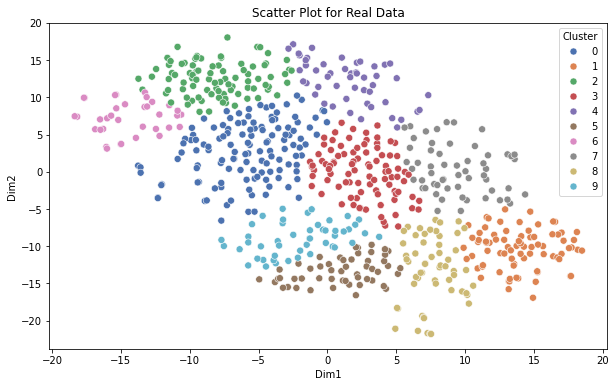

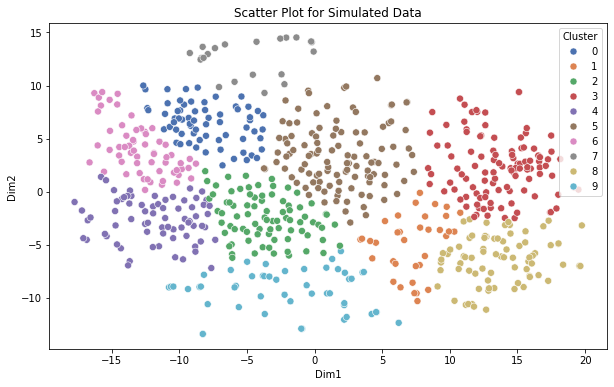

In [64]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_real = pd.DataFrame(real_encoded_reduced, columns=['Dim1', 'Dim2'])
df_real['Cluster'] = labels_real

df_simulated = pd.DataFrame(simulated_encoded_reduced, columns=['Dim1', 'Dim2'])
df_simulated['Cluster'] = labels_simulated

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_real, x='Dim1', y='Dim2', hue='Cluster', palette='deep', s=50)
plt.title('Scatter Plot for Real Data')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_simulated, x='Dim1', y='Dim2', hue='Cluster', palette='deep', s=50)
plt.title('Scatter Plot for Simulated Data')
plt.show()


In [65]:
n_runs = 10
bic_scores = []
for i in range(n_runs):
    gmm = GaussianMixture(n_components=10, random_state=i)
    gmm.fit(real_encoded_reduced)
    bic_scores.append(gmm.bic(real_encoded_reduced))

print(f"Mean BIC over {n_runs} runs: {np.mean(bic_scores):.4f}")
print(f"Standard deviation of BIC over {n_runs} runs: {np.std(bic_scores):.4f}")


Mean BIC over 10 runs: 9654.0062
Standard deviation of BIC over 10 runs: 4.6420


In [66]:
n_runs = 10
bic_scores = []
for i in range(n_runs):
    gmm = GaussianMixture(n_components=10, random_state=i)
    gmm.fit(simulated_encoded_reduced)
    bic_scores.append(gmm.bic(simulated_encoded_reduced))

print(f"Mean BIC over {n_runs} runs: {np.mean(bic_scores):.4f}")
print(f"Standard deviation of BIC over {n_runs} runs: {np.std(bic_scores):.4f}")


Mean BIC over 10 runs: 9471.4638
Standard deviation of BIC over 10 runs: 3.3555


In [ ]:
import os
from PIL import UnidentifiedImageError, Image
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader


def assign_clusters_to_images_with_pca(image_folder, encoder, gmm_model, transform):
    
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.webp', '.avif'))]
    print(f"Found {len(image_files)} images in the folder.")

    test_dataset = CustomImageDataset(img_dir=image_folder, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

   
    encoded_images = []
    valid_image_files = []  
    encoder.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            try:
                images = images.to(device)
                encoded = encoder(images)
                encoded = encoded.view(encoded.size(0), -1)
                encoded_images.append(encoded.cpu().numpy())
                valid_image_files.append(image_files[i])
            except UnidentifiedImageError as e:
                print(f"Error loading image {image_files[i]}: {e}")
            except Exception as e:
                print(f"Error processing image {image_files[i]}: {e}")

    if not encoded_images:
        print("No images were successfully encoded.")
        return [], [], []

    encoded_images = np.concatenate(encoded_images, axis=0)
    print(f"Successfully encoded {len(valid_image_files)} images.")


    pca = PCA(n_components=2, random_state=42)
    encoded_reduced = pca.fit_transform(encoded_images)


    assigned_clusters = gmm_model.predict(encoded_reduced)
    num_images = len(valid_image_files)
    cols = 3  # Number of columns
    rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)  
    plt.figure(figsize=(15, 5 * rows))
    for i, image_file in enumerate(valid_image_files):
        cluster_idx = assigned_clusters[i]
        img_path = os.path.join(image_folder, image_file)
        image = Image.open(img_path)
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f"Cluster: {cluster_idx}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return assigned_clusters, encoded_images, encoded_reduced

new_image_folder = '/user/HS400/sv00653/Desktop/kaggle/flower' 


assigned_clusters, encoded_images, encoded_reduced = assign_clusters_to_images_with_pca(new_image_folder, encoder, gmm_real, transform)


In [68]:
import numpy as np
import torch
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader


def flatten_data(loader):
    all_features = []
    for images, _ in loader:
        images = images.view(images.size(0), -1)  # Flatten the images
        all_features.append(images.numpy())
    return np.concatenate(all_features, axis=0)


real_features = flatten_data(real_image_loader)
fake_features = flatten_data(fake_image_loader)


kmeans_real = KMeans(n_clusters=10, random_state=42)
kmeans_real_labels = kmeans_real.fit_predict(real_features)


kmeans_fake = KMeans(n_clusters=10, random_state=42)
kmeans_fake_labels = kmeans_fake.fit_predict(fake_features)


hierarchical_real = AgglomerativeClustering(n_clusters=10)
hierarchical_real_labels = hierarchical_real.fit_predict(real_features)


hierarchical_fake = AgglomerativeClustering(n_clusters=10)
hierarchical_fake_labels = hierarchical_fake.fit_predict(fake_features)



def calculate_aic_bic(X, model):
   
    log_likelihood = -model.inertia_ / (2.0 * X.shape[1])

    
    num_params = model.n_clusters * X.shape[1] + model.n_clusters - 1

 
    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(X.shape[0]) * num_params - 2 * log_likelihood

    return aic, bic


kmeans_real_aic, kmeans_real_bic = calculate_aic_bic(real_features, kmeans_real)


kmeans_fake_aic, kmeans_fake_bic = calculate_aic_bic(fake_features, kmeans_fake)


def cross_validate_log_likelihood(X, n_clusters=10, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    log_likelihoods = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        model = KMeans(n_clusters=n_clusters, random_state=42)
        model.fit(X_train)
       
        inertia = model.inertia_  
        log_likelihood = -inertia / (2.0 * X_test.shape[1])
        log_likelihoods.append(log_likelihood)
       
    return np.mean(log_likelihoods), np.std(log_likelihoods)


kmeans_real_log_likelihood_mean, kmeans_real_log_likelihood_std = cross_validate_log_likelihood(real_features, n_clusters=10)

kmeans_fake_log_likelihood_mean, kmeans_fake_log_likelihood_std = cross_validate_log_likelihood(fake_features, n_clusters=10)

print("Real Data K-Means Results:")
print(f"AIC: {kmeans_real_aic}")
print(f"BIC: {kmeans_real_bic}")
print(f"Cross-Validation Log-Likelihood: {kmeans_real_log_likelihood_mean} (std: {kmeans_real_log_likelihood_std})")

print("\nFake Data K-Means Results:")
print(f"AIC: {kmeans_fake_aic}")
print(f"BIC: {kmeans_fake_bic}")
print(f"Cross-Validation Log-Likelihood: {kmeans_fake_log_likelihood_mean} (std: {kmeans_fake_log_likelihood_std})")


Real Data K-Means Results:
AIC: 983082.638554891
BIC: 3207986.130384862
Cross-Validation Log-Likelihood: -9.86261444091797 (std: 0.08252033929202708)

Fake Data K-Means Results:
AIC: 983083.7572453817
BIC: 3207987.2490753527
Cross-Validation Log-Likelihood: -10.248494338989257 (std: 0.07835065884716062)
